In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from keras.utils import to_categorical
from keras.models import Model, Sequential
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import h5py
from matplotlib import pyplot as plt
from PIL import Image
from time import time
import logging#程序进展信息
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split#分割数据集
#from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people#下载数据集
from sklearn.model_selection import GridSearchCV
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from scipy.io import loadmat

In [2]:
data = loadmat('jaffe_mean_data.mat')['jaffe_mean_data']

In [3]:
label = loadmat('cl_label.mat')['cl_label']

In [4]:
n_classes = label.shape[1]

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size=0.2,random_state=0)

In [6]:
random_state=0

In [7]:
n_components = 10

In [9]:
pca =PCA(svd_solver='randomized',n_components=n_components,whiten=True).fit(X_train)

In [10]:
X_train_pca = pca.transform(X_train)

In [11]:
X_val_pca = pca.transform(X_test)

In [12]:
eigenfaces = pca.components_.reshape((n_components, 256, 256))

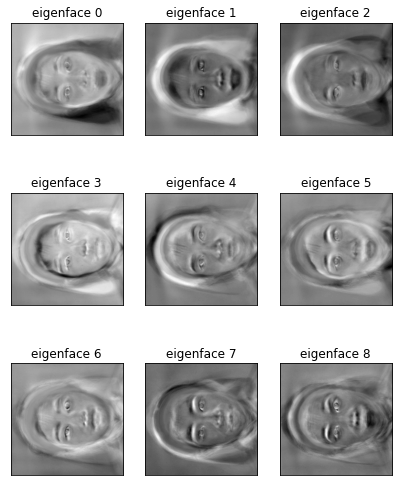

In [13]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=3):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
 
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, 256, 256)
plt.show()

In [14]:
y_train_ = np.argmax(Y_train, axis=-1)

In [15]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
#class_weight='balanced'
clf = clf.fit(X_train_pca, y_train_)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 0.945s
Best estimator found by grid search:
SVC(C=1000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [16]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_val_pca)
print("done in %0.3fs" % (time() - t0))
y_val = np.argmax(Y_test, axis=-1)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.001s
              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           2       1.00      1.00      1.00         7
           3       0.40      1.00      0.57         2
           4       1.00      0.80      0.89         5
           5       1.00      0.70      0.82        10
           6       0.86      0.75      0.80         8

    accuracy                           0.84        37
   macro avg       0.83      0.88      0.82        37
weighted avg       0.90      0.84      0.85        37

[[5 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0]
 [0 0 0 2 0 0 0]
 [0 0 0 1 4 0 0]
 [0 0 0 2 0 7 1]
 [2 0 0 0 0 0 6]]
